<h1 align=center><font size = 7>Locating A Chinese Restaurant in New York City or Toronto</font></h1>

# Part 1: Source, Scrape and Clean Toronto Location and Demographic Data

In this section, I will **scrape a website for data** to create a dataframe of boroughs and neighborhoods of Toronto.

Start by importing the needed libraries.

In [1]:
from bs4 import BeautifulSoup

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Use the libraries to scrape data from the site, use BeautifulSoup to extract **Toronto neighborhood table** from the Wikipedia site https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and putting the table into a dataframe.

In [2]:
url_text = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url_text, 'lxml')
# print(soup.prettify())  # View ice version of the html extract

# Extracting table portion from text
source_table = soup.find('table', {'class': 'wikitable sortable'})
# print(source_table) # View table extract from html

# Creating a blank dataframe to take the data from the table and intiate the dataframe
ToHoods = pd.DataFrame(columns = ['PostalCode', 'Borough', 'Neighborhood'])
# print(toronto_df.head()) # View bland dataframe

# Populating the blank dataframe, one line at a time, with data from the parsed site
# Extract the columns we want and write to the dataframe.
tags = source_table('tr') # Use beautiful soup extract line table('tr') to extract all rows
for tag in tags:
    tagtext = []
    tds = tag('td') # Use beautiful soup extract line row('td') to pick column entries in each row
    for td in tds:
        tagtext.append(td.get_text().strip()) # Convert column entried to string & remove space
    try:
        ToHoods = ToHoods.append({'PostalCode': tagtext[0], 'Borough': tagtext[1], 
                                    'Neighborhood': tagtext[2]}, ignore_index=True)
    except:
        continue

ToHoods.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Drop rows where the Borough is 'Not assigned' and reset index, show shape and view top five rows.

In [3]:
ToHoods.drop(ToHoods.index[ToHoods['Borough'] == 'Not assigned'], inplace = True)
ToHoods.reset_index(drop = True, inplace = True)
print(ToHoods.shape)
ToHoods.head()

(103, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Add location latitude and longitude to the dataframe from the csv made available at https://cocl.us/Geospatial_data.

In [4]:
# Use wget to import coodinate file from online location and save in coord_df dataframe
import wget
wget.download('https://cocl.us/Geospatial_data', 'coordinates.csv')
coord_df = pd.read_csv('coordinates.csv')

# Change column name of postal code in coord_df to match the ToHood dataframe
coord_df.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)
coord_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Add location latitude and longitude to the dataframe.

In [5]:
# merge ToHoods dataframe with coord_df to add latitude/longitude for each neighborhood in Toronto
ToHoods = ToHoods.join(coord_df.set_index('PostalCode'), on='PostalCode')
print(ToHoods.shape)
ToHoods.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Use the libraries to scrape data from the site, use BeautifulSoup to extract **Toronto Demographics table** from the wikipedia site https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods and putting the table into a dataframe.

In [6]:
url_text = requests.get('https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods').text
soup2 = BeautifulSoup(url_text, 'lxml')
# print(soup2.prettify())  # View ice version of the html extract

# Extracting all tables portion from text extract
demo_tables = soup2.find_all('table', {'class': 'wikitable sortable'})
# print(demo_tables)

# Extracting table headers from one table into a list
column_names = [item.get_text().strip() for item in demo_tables[0].find_all('th')]

# Creating a blank dataframe to take the data from the table and intiate the dataframe
# Selecting required headers into a blank dataframe
ToDemo = pd.DataFrame(columns = ['Borough', 'Neighborhood', column_names[3], column_names[7]])
# print(ToDemo) # View blank dataframe

# Find part of the site where boroughs are mentioned and put into a list
# To allow assignment to the borough column in the dataframe
boro_scrape = soup2.find_all('h3')
boro_list = []
borough = []
for item in boro_scrape:
    boro_list.append(item.get_text().strip()) # Extract items with borough names into a list
for i, var in enumerate(boro_list):
    if '[edit]' in var:
        borough.append(var[:-6]) # Clean up the list and remove unnecessary items
# print(borough)

# Extract data for each row from each table and add to the data frame
for x, table in enumerate(demo_tables):
    for item in table.select('tr'):
        tagtext2 = []
        tds = item.select('td') # Use beautiful soup extract line row('td') to pick column entries in each row
        for i, td in enumerate(tds):
            if i < 12:
                tagtext2.append(td.get_text().strip()) # Convert column entry to string & remove space
        try:
            ToDemo = ToDemo.append({'Borough': borough[x], 'Neighborhood': tagtext2[0],
                                    'Population': tagtext2[3], 'Average Income': tagtext2[7]}, ignore_index=True)
        except:
            continue

print(ToDemo.shape)
ToDemo.head()

(177, 4)


,Borough,Neighborhood,Population,Average Income
0,East York,Crescent Town,"8,157","23,021"
1,East York,Governor's Bridge/Bennington Heights,"2,112","129,904"
2,East York,Leaside,"13,876","82,670"
3,East York,O'Connor–Parkview,"17,740","33,517"
4,East York,Old East York,"52,220","33,172"


Drop rows where the rows where neighborhoods are blank and reset index, show shape and view top five rows.

In [7]:
ToDemo.drop(ToDemo.index[ToDemo['Neighborhood'] == ""], inplace = True)

ToDemo.reset_index(drop = True, inplace = True)

ToDemo['Population'] = ToDemo['Population'].str.replace(',', '').astype(int)
ToDemo['Average Income'] = ToDemo['Average Income'].str.replace(',', '').astype(int)

print(ToDemo.shape)

ToDemo.head()

(173, 4)


,Borough,Neighborhood,Population,Average Income
0,East York,Crescent Town,8157,23021
1,East York,Governor's Bridge/Bennington Heights,2112,129904
2,East York,Leaside,13876,82670
3,East York,O'Connor–Parkview,17740,33517
4,East York,Old East York,52220,33172


**Combine the ToHoods and ToDemo dataframes into a single dataframe toronto** with location and demographic data and tidy up.

In [8]:
# Merge the neighborhood and demographics data sets and drop any duplicate neighborhoods
toronto = pd.merge(ToHoods, ToDemo, how = 'inner', left_on = 'Neighborhood', right_on = 'Neighborhood')\
            .drop_duplicates('Neighborhood')

# Drop any rows without population data
toronto.dropna(subset = ['Latitude'], inplace = True)

# Drop Borough data from demo/census data because Borough from location data is more reliable 
# and rename Borough back to original
toronto.rename(columns = {'Borough_x': 'Borough'}, inplace = True)
toronto.reset_index(inplace = True, drop = True)
toronto.drop(['Borough_y'], axis = 1, inplace = True)

print(toronto.shape)
toronto.head()

(19, 7)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Average Income
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,34811
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,29657
2,M3B,North York,Don Mills,43.745906,-79.352188,21372,47515
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,14666,22341
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,20416,67536


**Use geopy library to get the latitude adn longitude of Toronto** naming our agent to_explorer.

In [9]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


**Create a bubble map of Toronto with neighborhoods superimposed and bubble sized to population.**

In [10]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, population, avg_income in zip(toronto['Latitude'], \
                                                                   toronto['Longitude'], \
                                                                   toronto['Borough'], \
                                                                   toronto['Neighborhood'],\
                                                                   toronto['Population'], \
                                                                   toronto['Average Income']):
    label = '{}, {}, {}'.format(neighborhood, borough, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=population/2000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### The map above shows to serves the most population in Toronto, restaurant would have to be located in Woburn, Agincourt or Downsview neighborhoods.###  

**What about if we create a bubble map of Toronto with neighborhoods superimposed and bubble sized to average income.**

In [11]:
# create map of New York using latitude and longitude values
map_toronto2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, population, avg_income in zip(toronto['Latitude'], \
                                                                   toronto['Longitude'], \
                                                                   toronto['Borough'], \
                                                                   toronto['Neighborhood'],\
                                                                   toronto['Population'], \
                                                                   toronto['Average Income']):
    label = '{}, {}, {}'.format(neighborhood, borough, avg_income)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=avg_income/10000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto2)  
    
map_toronto2

### The map above shows to serves the most affluent, with the most disposable income, in Toronto, restaurant would have to be located in Lawrence Park or Rosedale Downtown neighborhoods.###  

**This shows a significant income disparity in Toronto.  The neighborhoods with the most population have the lease disposable income, Perhaps there is a way to parse the data further to identify upper middle class neighborhoods with sizeable population.**

# Part 2: Source, Scrape and Clean New York Location & Demographic Data

In this section, I will **scrape a website for data** to create a dataframe of boroughs and neighborhoods of New York by scraping the dataset made available through link: https://geo.nyu.edu/catalog/nyu_2451_34572

Use wget to download data from the site, import json library to handle JSON files for **NewYork neighborhood table** and put the table into a dataframe.

In [12]:
import json # library to handle JSON files

target = 'https://cocl.us/new_york_dataset'

# Download from target and named 'newyork_data.json'
wget.download(target, 'newyork_data.json')

# use json library to parse data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
# Extract only the relevant portion of the json data
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the empty dataframe
nyHoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    # borough = neighborhood_name = data['properties']['borough'] 
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyHoods = nyHoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print(nyHoods.shape)
nyHoods.head()

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Now bringing in **New York Demographics table**.  Start by bringing in **neibourhood income table** from site https://ny.curbed.com/2017/8/4/16099252/new-york-neighborhood-affordability.  The data could not be scraped but table from site was downloaded into a csv file.  Loading that income csv file to dataframe.

In [13]:
nyIncome = pd.read_csv('newyork_income.csv')

# Select only the relevant columns in the table into the dataframe
nyIncome = nyIncome[["Neighborhood", "Borough", 'Median Household Income']]

# Rename income
nyIncome.rename(columns = {'Median Household Income': 'Income'}, inplace = True)

print(nyIncome.shape)
nyIncome.head()

(139, 3)


,Neighborhood,Borough,Income
0,Yorkville,Manhattan,98840
1,Woodside,Queens,50952
2,Woodhaven,Queens,61804
3,Windsor Terrace,Brooklyn,82297
4,Williamsburg,Brooklyn,21502


Now bringing in **neibourhood population table** from site https://data.cityofnewyork.us/api/views/swpk-hqdp/rows.csv?accessType=DOWNLOAD.  The data could not be scraped but table from site was downloaded into a csv file.  Loading that income csv file to dataframe.

In [14]:
target = 'https://data.cityofnewyork.us/api/views/swpk-hqdp/rows.csv?accessType=DOWNLOAD'

# Use wget to download from target and named 'ny_neighborhood_population.csv'
wget.download(target, 'ny_neighborhood_population.csv')

# Read file into a dataframe and select needed columns from the files and rename NTA Name to Neighborhood
nyPopulation = pd.read_csv('ny_neighborhood_population.csv')
nyPopulation = nyPopulation[['Borough', 'NTA Name', 'Population']]
nyPopulation.rename(columns = {'NTA Name': 'Neighborhood'}, inplace = True)

print(nyPopulation.shape)
nyPopulation.head()

(390, 3)


,Borough,Neighborhood,Population
0,Bronx,Claremont-Bathgate,28149
1,Bronx,Eastchester-Edenwald-Baychester,35422
2,Bronx,Bedford Park-Fordham North,55329
3,Bronx,Belmont,25967
4,Bronx,Bronxdale,34309


Combining New York Income and Population Demographic data.

In [15]:
# Drop duplicate rows and reset index
nyDemo = pd.merge(nyPopulation, nyIncome, how = 'inner', left_on = 'Neighborhood', right_on = 'Neighborhood')\
                    .drop_duplicates('Neighborhood')

# Tidy up columns: Rename Borough, remove extra Borough and reset index
nyDemo.rename(columns = {'Borough_x': 'Borough'}, inplace = True)
nyDemo.reset_index(inplace = True)
nyDemo.drop(['Borough_y', 'index'], axis = 1, inplace = True)

print(nyDemo.shape)
nyDemo.head()

(136, 4)


,Borough,Neighborhood,Population,Income
0,Bronx,Bedford Park-Fordham North,55329,29549
1,Bronx,West Farms-Bronx River,34542,29382
2,Bronx,Soundview-Castle Hill-Clason Point-Harding Park,50753,36129
3,Bronx,East Concourse-Concourse Village,58961,27883
4,Bronx,North Riverdale-Fieldston-Riverdale,28013,78895


**Combine the nyHoods and nyDemo dataframes into a single dataframe newyork** with location and demographic data and tidied up.

In [16]:
# Merge the neighborhood and demographics data sets and drop any duplicate neighborhoods
newyork = pd.merge(nyHoods, nyDemo, how = 'inner', left_on = 'Neighborhood', right_on = 'Neighborhood')\
                    .drop_duplicates('Neighborhood')

# Drop any rows without population data
newyork.dropna(subset = ['Latitude'], inplace = True)

# Drop Borough data from demo/census data because Borough from location data is more reliable 
# and rename Borough back to original
newyork.rename(columns = {'Borough_x': 'Borough'}, inplace = True)
newyork.reset_index(inplace = True, drop = True)
newyork.drop(['Borough_y'], axis = 1, inplace = True)

print(newyork.shape)
newyork.head()

(66, 6)


,Borough,Neighborhood,Latitude,Longitude,Population,Income
0,Bronx,Norwood,40.877224,-73.879391,40817,35319
1,Bronx,Pelham Parkway,40.857413,-73.854756,30006,47806
2,Bronx,Hunts Point,40.809730,-73.883315,25142,22572
3,Brooklyn,Bay Ridge,40.625801,-74.030621,80539,57980
4,Brooklyn,Greenpoint,40.730201,-73.954241,37821,67928


**Use geopy library to get the latitude adn longitude of New York** naming our agent to_explorer.

In [17]:
address2 = 'New York, NY'

geolocator2 = Nominatim(user_agent="ny_explorer")
location2 = geolocator.geocode(address2)
latitude2 = location2.latitude
longitude2 = location2.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude2, longitude2))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


**Create a bubble map of New York with neighborhoods superimposed and bubble sized by population.**

In [18]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude2, longitude2], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, population, avg_income in zip(newyork['Latitude'], \
                                                                   newyork['Longitude'], \
                                                                   newyork['Borough'], \
                                                                   newyork['Neighborhood'],\
                                                                   newyork['Population'], \
                                                                   newyork['Income']):
    label = '{}, {}, {}'.format(neighborhood, borough, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=population/7000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### The map above shows to serves the most population in New York city, restaurant would have to be located in Upper West Side Manhattan, Borough Park, Brooklyn, Flatbush, Brooklyn, Jackson Heights, Queens,  or Astoria Queens neighborhoods.###  

**What about if we create a bubble map of New York with neighborhoods superimposed and bubble sized to average income.**

In [19]:
# create map of New York using latitude and longitude values
map_newyork2 = folium.Map(location=[latitude2, longitude2], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, population, avg_income in zip(newyork['Latitude'], \
                                                                   newyork['Longitude'], \
                                                                   newyork['Borough'], \
                                                                   newyork['Neighborhood'],\
                                                                   newyork['Population'], \
                                                                   newyork['Income']):
    label = '{}, {}, {}'.format(neighborhood, borough, avg_income)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=avg_income/10000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork2)  
    
map_newyork2

### The map above shows that to serve the most affluent, with the most disposable income, in New York city, restaurant would have to be located in West Village, Manhattan, Lincoln Square Manhattan, Gramercy, Manhattan, or Yorkville Manhattan neighborhoods.###  

**This shows a significant income disparity in Toronto.  The neighborhoods with the most population have the lease disposable income, Perhaps there is a way to parse the data further to identify upper middle class neighborhoods with sizeable population.**

Let's combine the data frames for both cities and confirm this observation with a scatter plot.  the conclusion is not clear from the scatter plot, so further data cleanup is required.

(85, 7)


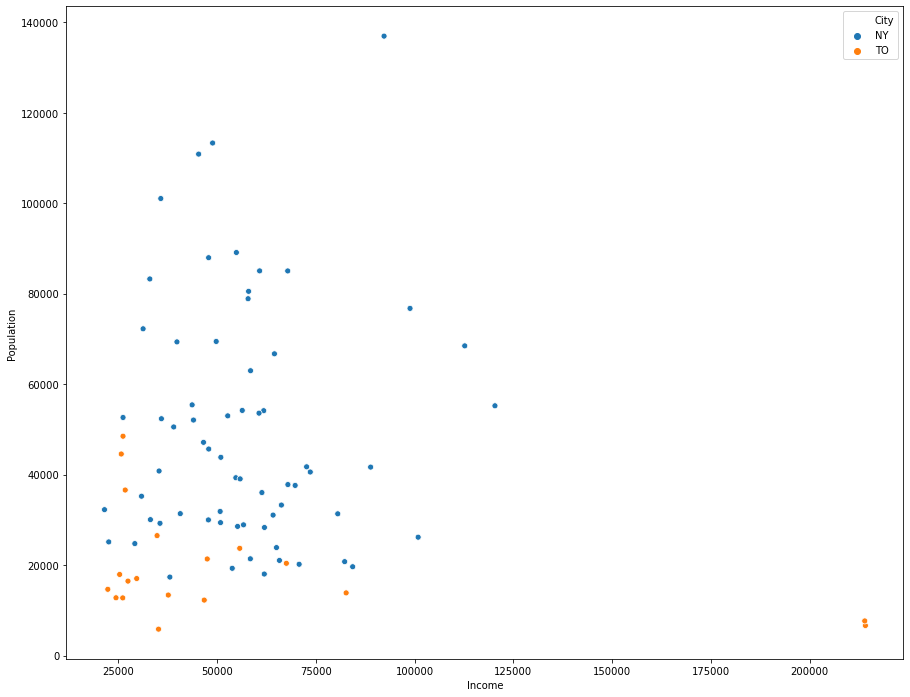

In [20]:
# Combine both dataframes into a new dataframe to facilitate other analysis

toronto_b = toronto.rename(columns = {'Average Income': 'Income'})
toronto_b['City'] = 'TO'

newyork_b = newyork.copy()
newyork_b['City'] = 'NY'
both_nyto = pd.concat([newyork_b, toronto_b], ignore_index = True)

both_nyto.drop('PostalCode', axis = 1, inplace = True)
print(both_nyto.shape)
# both_nyto.head()

plt.figure(figsize=(15,12))
sns.scatterplot(x = "Income", y = "Population", data = both_nyto, hue = 'City')

plt.show()

# Part 3: Data Analysis

In this section, I will deeper into the data for Toronto and New York to find the neighborhoods with the right balance of income and population for a restaurant.

Starting by taking a closer look at the data from the last two sections. Looking at the statistics for the demographics.

In [21]:
print(toronto.shape)
toronto[['Population', 'Average Income']].describe()

(19, 7)


,Population,Average Income
count,19.000000,19.000000
mean,19641.052632,56311.105263
std,11966.900938,57876.961791
min,5857.000000,22341.000000
25%,12781.000000,26153.500000
50%,16476.000000,34811.000000
75%,22549.500000,51625.000000
max,48507.000000,214110.000000


And then the demographics statistics for New York dataframe.

In [22]:
print(newyork.shape)
newyork[['Population', 'Income']].describe()

(66, 6)


,Population,Income
count,66.000000,66.000000
mean,49269.166667,56865.878788
std,26373.076524,20534.066868
min,17370.000000,21502.000000
25%,29554.500000,43771.750000
50%,41248.500000,55516.500000
75%,65790.750000,65598.250000
max,136954.000000,120337.000000


For both Toronto and New York, it appears the P25 and P75 income is sizeable enough and it will be interesting to see if there will be good-sized population in the neighborhoods that fall in that range. Again, the goal here is: **to find neighborhoods with above average income, to ensure good disposable income of clientelle, and above average population to ensure business for the restaurant.**  
 
Streamlining the dataframe for the two cities based on P50 and P75 incomes. Starting with Toronto.

In [23]:
toronto_stat = toronto[(toronto['Average Income'] > toronto['Average Income'].quantile(0.25)) & (toronto['Average Income'] < toronto['Average Income'].quantile(0.75))]

# Clean up the data frame
toronto_stat.reset_index(inplace = True, drop = True)

print(toronto_stat.shape)
toronto_stat.head()

(9, 7)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Average Income
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,34811
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,29657
2,M3B,North York,Don Mills,43.745906,-79.352188,21372,47515
3,M1G,Scarborough,Woburn,43.770992,-79.216917,48507,26190
4,M2K,North York,Bayview Village,43.786947,-79.385975,12280,46752


Now looking at New York dataframe

In [24]:
newyork_stat = newyork[(newyork['Income'] > newyork['Income'].quantile(0.25)) & (newyork['Income'] < newyork['Income'].quantile(0.75))]

# Clean up the data frame
newyork_stat.reset_index(inplace = True, drop = True)

print(newyork_stat.shape)
newyork_stat.head()

(32, 6)


,Borough,Neighborhood,Latitude,Longitude,Population,Income
0,Bronx,Pelham Parkway,40.857413,-73.854756,30006,47806
1,Brooklyn,Bay Ridge,40.625801,-74.030621,80539,57980
2,Brooklyn,Flatbush,40.636326,-73.958401,110875,45332
3,Brooklyn,Fort Greene,40.688527,-73.972906,28335,61990
4,Brooklyn,Canarsie,40.635564,-73.902093,85058,60766


**Looking at a bubble map of Toronto with neighborhoods superimposed and bubble sized to population using dataframe with interquartile filter applied.**

In [25]:
# create map of New York using latitude and longitude values
map_toronto3 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, population, avg_income in zip(toronto_stat['Latitude'], \
                                                                   toronto_stat['Longitude'], \
                                                                   toronto_stat['Borough'], \
                                                                   toronto_stat['Neighborhood'],\
                                                                   toronto_stat['Population'], \
                                                                   toronto_stat['Average Income']):
    label = '{}, {}, {}'.format(neighborhood, borough, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=population/2000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto3)  
    
map_toronto3

### In the map above, the outliers are gone and it shows a good sizeable population in Toronto in up to nine neighborhoods could be served by a restaurant.###  

**What about if we create a bubble map of Toronto with neighborhoods superimposed and bubble sized to average income.**

In [26]:
# create map of New York using latitude and longitude values
map_toronto4 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, population, avg_income in zip(toronto_stat['Latitude'], \
                                                                   toronto_stat['Longitude'], \
                                                                   toronto_stat['Borough'], \
                                                                   toronto_stat['Neighborhood'],\
                                                                   toronto_stat['Population'], \
                                                                   toronto_stat['Average Income']):
    label = '{}, {}, {}'.format(neighborhood, borough, avg_income)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=avg_income/3000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto4)  
    
map_toronto4

### When compared to the previous population map, the map above shows that the interquartile income filter has put the desired income in the same neighborhoods with sizeable population and neighborhoods with extremely high and extermely low incomes have been omitted, which also eliminated the extremely low and high populations as well.###  

**The neighborhoods with sizeable population fall interquartile income range with upper middle class having disposable income in neighborhoods with sizeable population.**

**Repeating the same exercise for New York with a bubble map of New York with neighborhoods superimposed and bubble sized by population using data with interquartile income filter.**

In [27]:
# create map of New York using latitude and longitude values
map_newyork3 = folium.Map(location=[latitude2, longitude2], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, population, avg_income in zip(newyork_stat['Latitude'], \
                                                                   newyork_stat['Longitude'], \
                                                                   newyork_stat['Borough'], \
                                                                   newyork_stat['Neighborhood'],\
                                                                   newyork_stat['Population'], \
                                                                   newyork_stat['Income']):
    label = '{}, {}, {}'.format(neighborhood, borough, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=population/7000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork3)  
    
map_newyork3

### As we saw in the Toronto Map, the interquartile income filter has removed extrem population neighborhoods in New York city.###  

**Let's see what the interquartile filter has done to the income map in a bubble map of New York with neighborhoods superimposed and bubble sized to average income.**

In [28]:
# create map of New York using latitude and longitude values
map_newyork4 = folium.Map(location=[latitude2, longitude2], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, population, avg_income in zip(newyork_stat['Latitude'], \
                                                                   newyork_stat['Longitude'], \
                                                                   newyork_stat['Borough'], \
                                                                   newyork_stat['Neighborhood'],\
                                                                   newyork_stat['Population'], \
                                                                   newyork_stat['Income']):
    label = '{}, {}, {}'.format(neighborhood, borough, avg_income)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=avg_income/10000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork4)  
    
map_newyork4

### Again as observed in the Toronto, the map above shows that the interquartile income filter has aligned the neighborhoods with good income with neighborhoods with the right population and extremely low and extremely high income neighborhoods have been omitted.###  

**This exercise shows that the right neighborhoods have been selected in Toronto and New York for further analyses.  Let's check if the scatter plot again.  It now shows clear demarcation between Toronto and New York City data as well as better inverse relationship**

(41, 7)


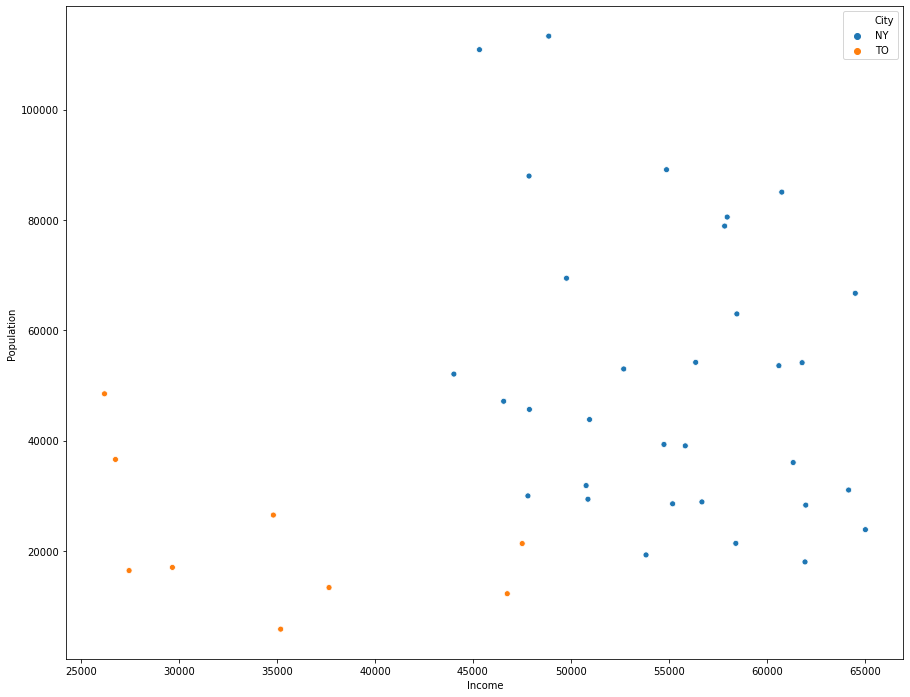

In [29]:
# Combine both dataframes into a new dataframe to facilitate other analysis

toronto_statb = toronto_stat.rename(columns = {'Average Income': 'Income'})
toronto_statb['City'] = 'TO'

newyork_statb = newyork_stat.copy()
newyork_statb['City'] = 'NY'
both_nyto_stat = pd.concat([newyork_statb, toronto_statb], ignore_index = True)

both_nyto_stat.drop('PostalCode', axis = 1, inplace = True)
print(both_nyto_stat.shape)
# both_nyto.head()

plt.figure(figsize=(15,12))
sns.scatterplot(x = "Income", y = "Population", data = both_nyto_stat, hue = 'City')

plt.show()

# Part 4: Analysis of Neighborhoods

In this section, Foursquare will be used to **evaluate restaurants in the neighborhoods in Toronto and New York** that were identified after filtering with the interquartile income in both cities.

Quick reminder of the dataframe after applying the inter-quartile filter.

First, for Toronto.

In [30]:
print(toronto_stat.shape)
toronto_stat.head(9)

(9, 7)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Population,Average Income
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,34811
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,29657
2,M3B,North York,Don Mills,43.745906,-79.352188,21372,47515
3,M1G,Scarborough,Woburn,43.770992,-79.216917,48507,26190
4,M2K,North York,Bayview Village,43.786947,-79.385975,12280,46752
5,M3K,North York,Downsview,43.737473,-79.464763,36613,26751
6,M9N,York,Weston,43.706876,-79.518188,16476,27446
7,M9P,Etobicoke,Westmount,43.696319,-79.532242,5857,35183
8,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,13397,37653


And then for New York.

In [31]:
print(newyork_stat.shape)
newyork_stat.head()

(32, 6)


,Borough,Neighborhood,Latitude,Longitude,Population,Income
0,Bronx,Pelham Parkway,40.857413,-73.854756,30006,47806
1,Brooklyn,Bay Ridge,40.625801,-74.030621,80539,57980
2,Brooklyn,Flatbush,40.636326,-73.958401,110875,45332
3,Brooklyn,Fort Greene,40.688527,-73.972906,28335,61990
4,Brooklyn,Canarsie,40.635564,-73.902093,85058,60766


#### Define Foursquare Credentials and Version

In [32]:
CLIENT_ID = '1ILYRCQSTQ52TLAHJSSVTDZ01WXPLZNUBX0EAEKJPU2KV4FS' # your Foursquare ID
CLIENT_SECRET = '012TKAPOSAALR55KAE4WNENFOFNDBT3BVEXOL2XOWDYQQZPI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 1ILYRCQSTQ52TLAHJSSVTDZ01WXPLZNUBX0EAEKJPU2KV4FS
CLIENT_SECRET:012TKAPOSAALR55KAE4WNENFOFNDBT3BVEXOL2XOWDYQQZPI


#### Update the getNearbyvenues function to pull up top 100 restaurants within 500m radius of each neighborhood in Downtown Toronto.

In [33]:
def getNearbyVenues(names, latitudes, longitudes, search_query, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue, first for neighborhood and then
        # for each venue from results above in each neighborhood
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Calling the function to get restaurants for the neighborhoods in Toronto.

In [34]:
toronto_venues = getNearbyVenues(names=toronto_stat['Neighborhood'],
                                   latitudes=toronto_stat['Latitude'],
                                   longitudes=toronto_stat['Longitude'],
                                   search_query='Restaurant'
                                  )

print(toronto_venues.shape)
toronto_venues.head()

Parkwoods
Victoria Village
Don Mills
Woburn
Bayview Village
Downsview
Weston
Westmount
Church and Wellesley
(89, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place


#### Calling the function to get restaurants for the neighborhoods in New York.

In [35]:
newyork_venues = getNearbyVenues(names=newyork_stat['Neighborhood'],
                                   latitudes=newyork_stat['Latitude'],
                                   longitudes=newyork_stat['Longitude'],
                                   search_query='Restaurant'
                                  )

print(newyork_venues.shape)
newyork_venues.head()

Pelham Parkway
Bay Ridge
Flatbush
Fort Greene
Canarsie
Flatlands
Bath Beach
Dyker Heights
East Williamsburg
Murray Hill
Morningside Heights
Astoria
Woodside
Jackson Heights
Elmhurst
Corona
Kew Gardens
Richmond Hill
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
South Ozone Park
College Point
Kew Gardens Hills
Steinway
Queensboro Hill
North Corona
Port Richmond
Homecrest
Madison
(1025, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pelham Parkway,40.857413,-73.854756,Enzo's,40.854232,-73.854362,Italian Restaurant
1,Pelham Parkway,40.857413,-73.854756,Mr. Q's Chinese Restaurant,40.855790,-73.855455,Chinese Restaurant
2,Pelham Parkway,40.857413,-73.854756,Sorrento Pizzeria,40.854389,-73.854520,Pizza Place
3,Pelham Parkway,40.857413,-73.854756,Dunkin',40.856383,-73.856159,Donut Shop
4,Pelham Parkway,40.857413,-73.854756,Venezia Pizzeria,40.859812,-73.855224,Pizza Place


Checking how many venues were returned for each neighborhoods in Toronto.

In [36]:
TO_count = (toronto_venues.groupby('Neighborhood').count()).iloc[:, 0].to_frame()
TO_count.rename(columns = {'Neighborhood Latitude': 'Restaurant Count'}, inplace = True)
TO_count.sort_values(by = 'Restaurant Count', ascending = False, inplace = True)
print(TO_count.shape)
TO_count.head()

(8, 1)


,Restaurant Count
Neighborhood,
Church and Wellesley,65
Don Mills,6
Westmount,5
Bayview Village,4
Victoria Village,3


Checking how many venues were returned for each neighborhoods in Neighborhood.

In [37]:
NY_count = (newyork_venues.groupby('Neighborhood').count()).iloc[:, 0].to_frame()
NY_count.rename(columns = {'Neighborhood Latitude': 'Restaurant Count'}, inplace = True)
NY_count.sort_values(by = 'Restaurant Count', ascending = False, inplace = True)
print(NY_count.shape)
NY_count.head()

(32, 1)


,Restaurant Count
Neighborhood,
Astoria,88
Murray Hill,81
Bay Ridge,75
Woodside,67
Jackson Heights,64


**Adding restaurant count to Toronto and New York dataframes, adding cities to both tables and combining the two tables into one to do a comparative analysis.**

In [38]:
# Adding restaurant count and city to both dataframes
# First for Toronto
toronto_stat2 = toronto_stat.join(TO_count, on = 'Neighborhood')
toronto_stat2['City'] = 'TO'
toronto_stat2['restaurant per capita'] = toronto_stat2['Restaurant Count'] * 100000 / toronto_stat2['Population']
toronto_stat2.drop('PostalCode', axis = 1, inplace = True)
toronto_stat2.rename(columns = {'Average Income': 'Income'}, inplace = True)
print(toronto_stat2.shape)
print(toronto_stat2.head())

# Now for New York
newyork_stat2 = newyork_stat.join(NY_count, on = 'Neighborhood')
newyork_stat2['City'] = 'NY'
newyork_stat2['restaurant per capita'] = newyork_stat2['Restaurant Count'] * 100000 / newyork_stat2['Population']
print(newyork_stat2.shape)
newyork_stat2.head()

(9, 9)
       Borough      Neighborhood   Latitude  Longitude  Population  Income  \
0   North York         Parkwoods  43.753259 -79.329656       26533   34811   
1   North York  Victoria Village  43.725882 -79.315572       17047   29657   
2   North York         Don Mills  43.745906 -79.352188       21372   47515   
3  Scarborough            Woburn  43.770992 -79.216917       48507   26190   
4   North York   Bayview Village  43.786947 -79.385975       12280   46752   

   Restaurant Count City  restaurant per capita  
0               2.0   TO               7.537783  
1               3.0   TO              17.598404  
2               6.0   TO              28.074116  
3               3.0   TO               6.184674  
4               4.0   TO              32.573290  
(32, 9)


,Borough,Neighborhood,Latitude,Longitude,Population,Income,Restaurant Count,City,restaurant per capita
0,Bronx,Pelham Parkway,40.857413,-73.854756,30006,47806,15,NY,49.990002
1,Brooklyn,Bay Ridge,40.625801,-74.030621,80539,57980,75,NY,93.122587
2,Brooklyn,Flatbush,40.636326,-73.958401,110875,45332,20,NY,18.038331
3,Brooklyn,Fort Greene,40.688527,-73.972906,28335,61990,49,NY,172.931004
4,Brooklyn,Canarsie,40.635564,-73.902093,85058,60766,7,NY,8.229679


Now combining the two into a new dataframe named 'nyto' and **adding column for restaurant per capita in restaurant per 100,000 residents in each neighborhood.**

In [39]:
# Combine both dataframes into a new dataframe to facilitate other analysis and a column for 
# restaurant per/capita in number per 100,000

nyto = pd.concat([newyork_stat2, toronto_stat2], ignore_index = True)
nyto.sort_values(by = ['City', 'Income'], ascending = [False, True], inplace = True)
nyto.dropna(axis = 0, inplace = True)
nyto.reset_index(drop = True, inplace = True)

print(nyto.shape)
nyto.head()

(40, 9)


,Borough,Neighborhood,Latitude,Longitude,Population,Income,Restaurant Count,City,restaurant per capita
0,Scarborough,Woburn,43.770992,-79.216917,48507,26190,3.0,TO,6.184674
1,North York,Downsview,43.737473,-79.464763,36613,26751,1.0,TO,2.731270
2,North York,Victoria Village,43.725882,-79.315572,17047,29657,3.0,TO,17.598404
3,North York,Parkwoods,43.753259,-79.329656,26533,34811,2.0,TO,7.537783
4,Etobicoke,Westmount,43.696319,-79.532242,5857,35183,5.0,TO,85.367936


Looking at the statistics of the restaurant per capita and income in the combined dataframe.

In [40]:
nyto[['restaurant per capita', 'Income']].describe()

,restaurant per capita,Income
count,40.000000,40.000000
mean,76.570865,51260.625000
std,86.724677,10212.944403
min,2.731270,26190.000000
25%,23.493657,47324.250000
50%,44.411400,53266.000000
75%,99.992986,58433.250000
max,485.183250,65035.000000


Looking at restaurant per capita box plot to look for outliers.

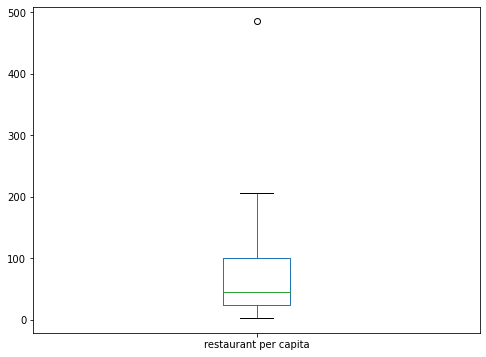

In [41]:
nyto['restaurant per capita'].plot(kind='box', figsize=(8, 6))

The boxplot above shows an outlier above 300.  Now looking at Income box plot to look for outliers.

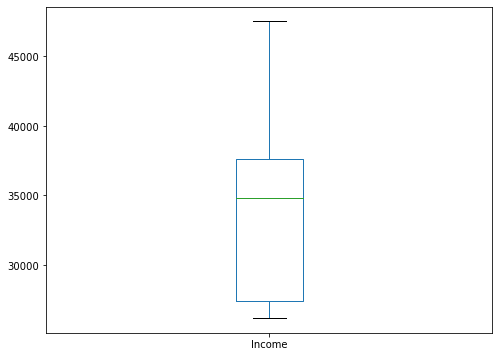

In [42]:
toronto_stat2['Income'].plot(kind='box', figsize=(8, 6))

**An outlier in restaurant per capita above 400.  We can use that to streamline the data further.**

In [43]:
# Filtering out the outliers from the data.
# First combined data
nyto = nyto[nyto['restaurant per capita'] < 400]
print(nyto.shape)
print(nyto.head())

# Now for Toronto
toronto_stat2 = toronto_stat2[toronto_stat2['restaurant per capita'] < 400]
print(toronto_stat2.shape)
print(toronto_stat2.head())

# Now for New York
newyork_stat2 = newyork_stat2[newyork_stat2['restaurant per capita'] < 400]
print(newyork_stat2.shape)
newyork_stat2.head()

(39, 9)
       Borough      Neighborhood   Latitude  Longitude  Population  Income  \
0  Scarborough            Woburn  43.770992 -79.216917       48507   26190   
1   North York         Downsview  43.737473 -79.464763       36613   26751   
2   North York  Victoria Village  43.725882 -79.315572       17047   29657   
3   North York         Parkwoods  43.753259 -79.329656       26533   34811   
4    Etobicoke         Westmount  43.696319 -79.532242        5857   35183   

   Restaurant Count City  restaurant per capita  
0               3.0   TO               6.184674  
1               1.0   TO               2.731270  
2               3.0   TO              17.598404  
3               2.0   TO               7.537783  
4               5.0   TO              85.367936  
(7, 9)
       Borough      Neighborhood   Latitude  Longitude  Population  Income  \
0   North York         Parkwoods  43.753259 -79.329656       26533   34811   
1   North York  Victoria Village  43.725882 -79.315572      

,Borough,Neighborhood,Latitude,Longitude,Population,Income,Restaurant Count,City,restaurant per capita
0,Bronx,Pelham Parkway,40.857413,-73.854756,30006,47806,15,NY,49.990002
1,Brooklyn,Bay Ridge,40.625801,-74.030621,80539,57980,75,NY,93.122587
2,Brooklyn,Flatbush,40.636326,-73.958401,110875,45332,20,NY,18.038331
3,Brooklyn,Fort Greene,40.688527,-73.972906,28335,61990,49,NY,172.931004
4,Brooklyn,Canarsie,40.635564,-73.902093,85058,60766,7,NY,8.229679


Looking at restaurant per capita box plot to look for outliers.

#### Lets look for potential distinguishing trends between neighborhoods in Toronto.

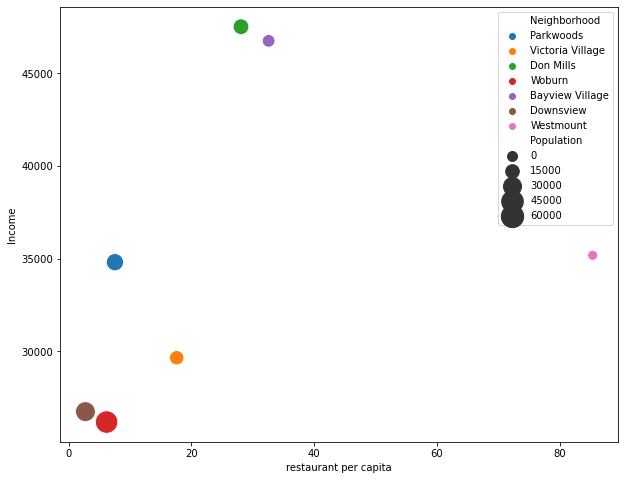

In [44]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.scatterplot(x = "restaurant per capita", y = "Income", data = toronto_stat2, hue = 'Neighborhood', size = "Population",
                sizes = (100, 500))

plt.show()

### The plot above shows that the neighborhoods of Don Mills, followed closely by Bayview village are the best neigborhoods to locate a restaurant with low restaurant per capita and high neighborhood income.

#### Lets look for potential distinguishing trends between neighborhoods in New York.

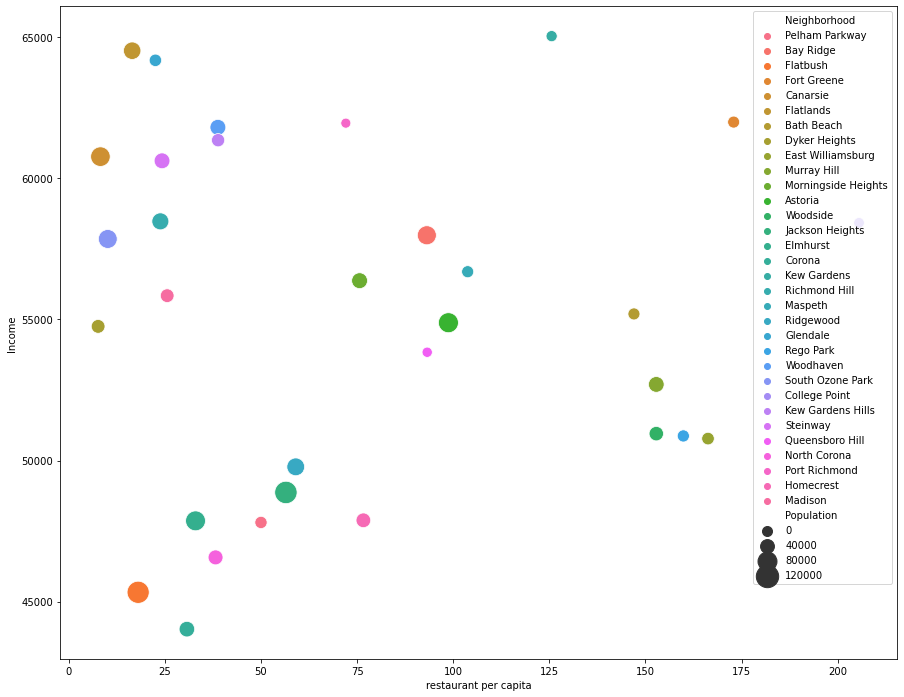

In [45]:

plt.figure(figsize=(15,12))
sns.scatterplot(x = "restaurant per capita", y = "Income", data = newyork_stat2, hue = 'Neighborhood', size = "Population",
                sizes = (100, 500))

plt.show()

In [46]:
newyork_stat2.sort_values(by = 'Income', ascending = False, inplace = True)
newyork_stat2.head(10)

,Borough,Neighborhood,Latitude,Longitude,Population,Income,Restaurant Count,City,restaurant per capita
16,Queens,Kew Gardens,40.705179,-73.829819,23888,65035,30,NY,125.586068
5,Brooklyn,Flatlands,40.630446,-73.929113,66726,64519,11,NY,16.485328
20,Queens,Glendale,40.702762,-73.870742,31071,64178,7,NY,22.529046
3,Brooklyn,Fort Greene,40.688527,-73.972906,28335,61990,49,NY,172.931004
29,Staten Island,Port Richmond,40.633669,-74.129434,18042,61952,13,NY,72.054096
22,Queens,Woodhaven,40.689887,-73.858110,54149,61804,21,NY,38.781880
25,Queens,Kew Gardens Hills,40.722578,-73.820878,36052,61348,14,NY,38.832797
4,Brooklyn,Canarsie,40.635564,-73.902093,85058,60766,7,NY,8.229679
26,Queens,Steinway,40.775923,-73.902290,53604,60618,13,NY,24.251921
17,Queens,Richmond Hill,40.697947,-73.831833,62985,58473,15,NY,23.815194


### The plot and table above show that the neighborhoods of Flatlands, Glendale, Canarsie and Steinway are the most suitable to locate a new Chinese restaurant given low restaurant per capita and high income residents.

#### Let's pull the four winning neighborhoods from New York and the two from Toronto into a new dataframe for a closer look.

In [47]:
winner_neighborhoods = ['Flatlands', 'Glendale', 'Don Mills', 'Bayview Village', 'Canarsie', 'Steinway']
winners = nyto[nyto['Neighborhood'].isin(winner_neighborhoods)]
#winners.sort_values(by = 'restaurant per capita', ascending = True, inplace = True)
winners.reset_index(inplace = True, drop = True)
winners.head(6)

,Borough,Neighborhood,Latitude,Longitude,Population,Income,Restaurant Count,City,restaurant per capita
0,North York,Bayview Village,43.786947,-79.385975,12280,46752,4.0,TO,32.573290
1,North York,Don Mills,43.745906,-79.352188,21372,47515,6.0,TO,28.074116
2,Queens,Steinway,40.775923,-73.902290,53604,60618,13.0,NY,24.251921
3,Brooklyn,Canarsie,40.635564,-73.902093,85058,60766,7.0,NY,8.229679
4,Queens,Glendale,40.702762,-73.870742,31071,64178,7.0,NY,22.529046
5,Brooklyn,Flatlands,40.630446,-73.929113,66726,64519,11.0,NY,16.485328


#### Lets look four winning communities on a plot.

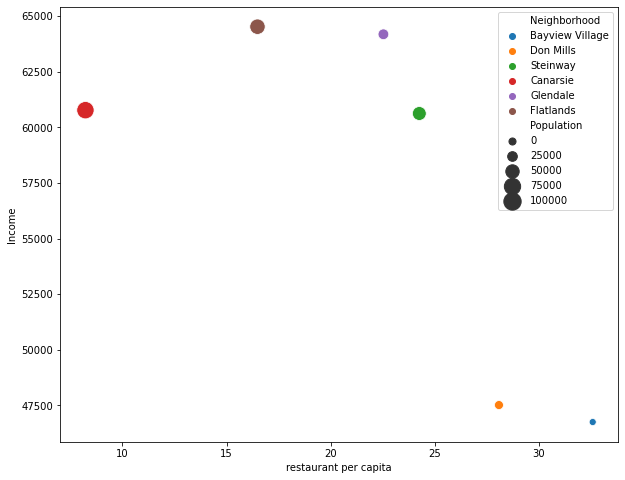

In [48]:
plt.figure(figsize=(10,8))
sns.scatterplot(x = "restaurant per capita", y = "Income", data = winners, hue = 'Neighborhood', size = "Population",
                sizes = (50, 300))

plt.show()

# The plot above shows that the neighborhoods of Canarsie and Flatlands in New York is the best location based on low restaurant per capita and higher neighborhood income.  Carnasie is the best given the relatively low restaurants per capita.

# Part 5: Neighborhood Confirmation Analysis

In this section, we'll run detailed neighborhood analysis to make sure the few restaurants in our winner neighborhoods are not Chinese restaurants that will compete with the new Chinese restaurant.

## Analyzing each neighborhood.

#### First let's rerun restaurant venues by calling the function to get restaurants for the neighborhoods in Toronto using the filtered Toronto data.

In [49]:
toronto_venues = getNearbyVenues(names=toronto_stat2['Neighborhood'],
                                   latitudes=toronto_stat2['Latitude'],
                                   longitudes=toronto_stat2['Longitude'],
                                   search_query='Restaurant'
                                  )

print(toronto_venues.shape)
toronto_venues.head()

Parkwoods
Victoria Village
Don Mills
Woburn
Bayview Village
Downsview
Westmount
(24, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place


#### Let's repeat for New York by calling the function to get restaurants for the neighborhoods in New York with the most recent filtered data.

In [50]:
newyork_venues = getNearbyVenues(names=newyork_stat2['Neighborhood'],
                                   latitudes=newyork_stat2['Latitude'],
                                   longitudes=newyork_stat2['Longitude'],
                                   search_query='Restaurant'
                                  )

print(newyork_venues.shape)
newyork_venues.head()

Kew Gardens
Flatlands
Glendale
Fort Greene
Port Richmond
Woodhaven
Kew Gardens Hills
Canarsie
Steinway
Richmond Hill
College Point
Bay Ridge
South Ozone Park
Maspeth
Morningside Heights
Madison
Bath Beach
Astoria
Dyker Heights
Queensboro Hill
Murray Hill
Woodside
Rego Park
East Williamsburg
Ridgewood
Jackson Heights
Homecrest
Elmhurst
Pelham Parkway
North Corona
Flatbush
Corona
(1025, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kew Gardens,40.705179,-73.829819,Tu Casa Restaurant,40.706113,-73.831586,South American Restaurant
1,Kew Gardens,40.705179,-73.829819,Tikka Indian Grill,40.705874,-73.830942,Indian Restaurant
2,Kew Gardens,40.705179,-73.829819,Alba's Grocery & Deli,40.706002,-73.831361,Deli / Bodega
3,Kew Gardens,40.705179,-73.829819,Baker's Dozen Bagels,40.709104,-73.830020,Bagel Shop
4,Kew Gardens,40.705179,-73.829819,Dani's House of Pizza,40.708982,-73.830536,Pizza Place


Finding how many unique categories there are in each city dataframes.  Let's go back to the original venue dataframes.

In [51]:
print('There are {} Toronto unique restaurants and {} New York unique restaurants.'.format(len(toronto_venues['Venue Category'].unique()), len(newyork_venues['Venue Category'].unique())))

There are 18 Toronto unique restaurants and 94 New York unique restaurants.


In [52]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood']

# move neighborhood column to the first column
fixedto_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
fixedny_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])


# print(list(manhattan_onehot.columns[:-1])) to understand that the list represents contents of that column
toronto_onehot = toronto_onehot[fixedto_columns]
newyork_onehot = newyork_onehot[fixedny_columns]

print(toronto_onehot.head())
newyork_onehot.head()

       Neighborhood  Asian Restaurant  BBQ Joint  Café  Caribbean Restaurant  \
0         Parkwoods                 0          0     0                     0   
1         Parkwoods                 0          1     0                     0   
2  Victoria Village                 0          0     0                     0   
3  Victoria Village                 0          0     0                     0   
4  Victoria Village                 0          0     0                     0   

   Chinese Restaurant  Fast Food Restaurant  French Restaurant  \
0                   0                     1                  0   
1                   0                     0                  0   
2                   0                     0                  0   
3                   0                     0                  1   
4                   0                     0                  0   

   Indian Restaurant  Italian Restaurant  Japanese Restaurant  \
0                  0                   0                 

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Kew Gardens,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Kew Gardens,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kew Gardens,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Kew Gardens,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Kew Gardens,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Examining the dataframe.

In [53]:
print(toronto_onehot.shape, newyork_onehot.shape)

(24, 19) (1025, 95)


#### Group rows by neighborhood and find the mean of the frequence of occurence.

In [54]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()

print(toronto_grouped.head())
print(newyork_grouped.head())

       Neighborhood  Asian Restaurant  BBQ Joint      Café  \
0   Bayview Village              0.25        0.0  0.250000   
1         Don Mills              0.00        0.0  0.166667   
2         Downsview              0.00        0.0  0.000000   
3         Parkwoods              0.00        0.5  0.000000   
4  Victoria Village              0.00        0.0  0.000000   

   Caribbean Restaurant  Chinese Restaurant  Fast Food Restaurant  \
0              0.000000                0.25                   0.0   
1              0.166667                0.00                   0.0   
2              0.000000                0.00                   0.0   
3              0.000000                0.00                   0.5   
4              0.000000                0.00                   0.0   

   French Restaurant  Indian Restaurant  Italian Restaurant  \
0           0.000000                0.0            0.000000   
1           0.000000                0.0            0.166667   
2           0.000000   

Confirming the new size.

In [55]:
print(toronto_grouped.shape, newyork_grouped.shape)

(7, 19) (32, 95)


## Printing each neighborhood in Toronto and New York with 10 most common restaurants.

Write a function sorting the venues in descending order.

In [56]:
def return_most_common_restaurants(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now creating a dataframe with the top 10 restaurant types in each neighborhood.

In [57]:
num_top_restaurants = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top restaurantw
columns = ['Neighborhood']
for ind in np.arange(num_top_restaurants):
    try:
        columns.append('{}{} Most Common Restaurants'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurants'.format(ind+1))

# create new dataframes
tohoods_restaurants_sorted = pd.DataFrame(columns=columns)
nyhoods_restaurants_sorted = pd.DataFrame(columns=columns)

tohoods_restaurants_sorted['Neighborhood'] = toronto_grouped['Neighborhood']
nyhoods_restaurants_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    tohoods_restaurants_sorted.iloc[ind, 1:] = return_most_common_restaurants(toronto_grouped.iloc[ind, :], num_top_restaurants)
    
for ind in np.arange(newyork_grouped.shape[0]):
    nyhoods_restaurants_sorted.iloc[ind, 1:] = return_most_common_restaurants(newyork_grouped.iloc[ind, :], num_top_restaurants)

print(tohoods_restaurants_sorted.head())
nyhoods_restaurants_sorted.head()

       Neighborhood 1st Most Common Restaurants 2nd Most Common Restaurants  \
0   Bayview Village            Asian Restaurant                        Café   
1         Don Mills          Italian Restaurant                  Restaurant   
2         Downsview                 Snack Place              Sandwich Place   
3         Parkwoods                   BBQ Joint        Fast Food Restaurant   
4  Victoria Village       Portuguese Restaurant                 Pizza Place   

  3rd Most Common Restaurants 4th Most Common Restaurants  \
0          Chinese Restaurant         Japanese Restaurant   
1                        Café        Caribbean Restaurant   
2                   BBQ Joint                        Café   
3                 Snack Place              Sandwich Place   
4           French Restaurant                 Snack Place   

  5th Most Common Restaurants 6th Most Common Restaurants  \
0           Indian Restaurant                   BBQ Joint   
1         Japanese Restaurant       

,Neighborhood,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
0,Astoria,Middle Eastern Restaurant,Deli / Bodega,Indian Restaurant,Bakery,Greek Restaurant,Pizza Place,Mediterranean Restaurant,Café,Seafood Restaurant,Food Truck
1,Bath Beach,Chinese Restaurant,Pizza Place,Asian Restaurant,Cantonese Restaurant,Donut Shop,Sushi Restaurant,Italian Restaurant,Fast Food Restaurant,Halal Restaurant,Kebab Restaurant
2,Bay Ridge,Pizza Place,Italian Restaurant,Chinese Restaurant,Bagel Shop,Greek Restaurant,Diner,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Fast Food Restaurant
3,Canarsie,Food,Deli / Bodega,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Caribbean Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant
4,College Point,Pizza Place,Deli / Bodega,Bakery,Mexican Restaurant,Latin American Restaurant,Asian Restaurant,Chinese Restaurant,Seafood Restaurant,Italian Restaurant,Taco Place


# Clustering the neighborhoods

Running k-mean to cluster the neighborhoods into five clusters.

In [58]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_to = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans_ny = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans_to.labels_[0:10])
kmeans_ny.labels_[0:10] 

[2 2 1 3 0 2 2]


array([3, 3, 3, 3, 1, 1, 2, 1, 3, 1])

Creating  new dataframe that contains the cluseters and the top 10 venues for each neighborhood.

In [59]:
# add clustering labels
tohoods_restaurants_sorted.insert(0, 'Cluster Labels', kmeans_to.labels_)
nyhoods_restaurants_sorted.insert(0, 'Cluster Labels', kmeans_ny.labels_)

toronto_merged = toronto
newyork_merged = newyork

# merge dt_toronto_grouped with dt_toronto to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(tohoods_restaurants_sorted.set_index('Neighborhood'), on='Neighborhood')
newyork_merged = newyork_merged.join(nyhoods_restaurants_sorted.set_index('Neighborhood'), on='Neighborhood')

print(toronto_merged.head()) # check the last columns!
newyork_merged.head()

  PostalCode           Borough      Neighborhood   Latitude  Longitude  \
0        M3A        North York         Parkwoods  43.753259 -79.329656   
1        M4A        North York  Victoria Village  43.725882 -79.315572   
2        M3B        North York         Don Mills  43.745906 -79.352188   
3        M5C  Downtown Toronto    St. James Town  43.651494 -79.375418   
4        M4E      East Toronto       The Beaches  43.676357 -79.293031   

   Population  Average Income  Cluster Labels 1st Most Common Restaurants  \
0       26533           34811             3.0                   BBQ Joint   
1       17047           29657             0.0       Portuguese Restaurant   
2       21372           47515             2.0          Italian Restaurant   
3       14666           22341             NaN                         NaN   
4       20416           67536             NaN                         NaN   

  2nd Most Common Restaurants 3rd Most Common Restaurants  \
0        Fast Food Restaurant  

,Borough,Neighborhood,Latitude,Longitude,Population,Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
0,Bronx,Norwood,40.877224,-73.879391,40817,35319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bronx,Pelham Parkway,40.857413,-73.854756,30006,47806,3.0,Deli / Bodega,Chinese Restaurant,Italian Restaurant,Pizza Place,Sushi Restaurant,Sandwich Place,Mexican Restaurant,Café,Food,Donut Shop
2,Bronx,Hunts Point,40.809730,-73.883315,25142,22572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Brooklyn,Bay Ridge,40.625801,-74.030621,80539,57980,3.0,Pizza Place,Italian Restaurant,Chinese Restaurant,Bagel Shop,Greek Restaurant,Diner,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Fast Food Restaurant
4,Brooklyn,Greenpoint,40.730201,-73.954241,37821,67928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# drop nan rows in merged data

toronto_merged.dropna(axis = 0, inplace = True)
newyork_merged.dropna(axis = 0, inplace = True)

toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
newyork_merged['Cluster Labels'] = newyork_merged['Cluster Labels'].astype(int)

print(toronto_merged.head()) # check the last columns!
newyork_merged.head()

  PostalCode      Borough      Neighborhood   Latitude  Longitude  Population  \
0        M3A   North York         Parkwoods  43.753259 -79.329656       26533   
1        M4A   North York  Victoria Village  43.725882 -79.315572       17047   
2        M3B   North York         Don Mills  43.745906 -79.352188       21372   
5        M1G  Scarborough            Woburn  43.770992 -79.216917       48507   
9        M2K   North York   Bayview Village  43.786947 -79.385975       12280   

   Average Income  Cluster Labels 1st Most Common Restaurants  \
0           34811               3                   BBQ Joint   
1           29657               0       Portuguese Restaurant   
2           47515               2          Italian Restaurant   
5           26190               2           Indian Restaurant   
9           46752               2            Asian Restaurant   

  2nd Most Common Restaurants 3rd Most Common Restaurants  \
0        Fast Food Restaurant                 Snack Place   


,Borough,Neighborhood,Latitude,Longitude,Population,Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
1,Bronx,Pelham Parkway,40.857413,-73.854756,30006,47806,3,Deli / Bodega,Chinese Restaurant,Italian Restaurant,Pizza Place,Sushi Restaurant,Sandwich Place,Mexican Restaurant,Café,Food,Donut Shop
3,Brooklyn,Bay Ridge,40.625801,-74.030621,80539,57980,3,Pizza Place,Italian Restaurant,Chinese Restaurant,Bagel Shop,Greek Restaurant,Diner,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Fast Food Restaurant
7,Brooklyn,Flatbush,40.636326,-73.958401,110875,45332,1,Deli / Bodega,Bakery,Chinese Restaurant,Mexican Restaurant,Caribbean Restaurant,Bagel Shop,Diner,Middle Eastern Restaurant,Food Truck,Sandwich Place
11,Brooklyn,Fort Greene,40.688527,-73.972906,28335,61990,3,Pizza Place,Italian Restaurant,Mexican Restaurant,American Restaurant,Southern / Soul Food Restaurant,New American Restaurant,Bagel Shop,French Restaurant,Restaurant,Japanese Restaurant
13,Brooklyn,Canarsie,40.635564,-73.902093,85058,60766,3,Food,Deli / Bodega,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Caribbean Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant


Visualizing the resulting clusters for Toronto.

In [61]:
# create map
map_clusters_to = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors_to = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_to)
       
map_clusters_to

Visualizing the resulting clusters for New York.

In [62]:
# create map
map_clusters_ny = folium.Map(location=[latitude2, longitude2], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors_ny = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_ny)
       
map_clusters_ny

# Examing the Clusters for Toronto

### Cluster 1

In [63]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Population,Average Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
1,Victoria Village,17047,29657,0,Portuguese Restaurant,Pizza Place,French Restaurant,Snack Place,Indian Restaurant,BBQ Joint,Café,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant


### Cluster 2

In [64]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Population,Average Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
10,Downsview,36613,26751,1,Snack Place,Sandwich Place,BBQ Joint,Café,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant


### Cluster 3

In [65]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Population,Average Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
2,Don Mills,21372,47515,2,Italian Restaurant,Restaurant,Café,Caribbean Restaurant,Japanese Restaurant,Sandwich Place,French Restaurant,BBQ Joint,Chinese Restaurant,Fast Food Restaurant
5,Woburn,48507,26190,2,Indian Restaurant,Mexican Restaurant,Korean Restaurant,Snack Place,BBQ Joint,Café,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant
9,Bayview Village,12280,46752,2,Asian Restaurant,Café,Chinese Restaurant,Japanese Restaurant,Indian Restaurant,BBQ Joint,Caribbean Restaurant,Fast Food Restaurant,French Restaurant,Snack Place
14,Westmount,5857,35183,2,Restaurant,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Sandwich Place,Snack Place,French Restaurant,BBQ Joint,Café,Caribbean Restaurant


### Cluster 4

In [66]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Population,Average Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
0,Parkwoods,26533,34811,3,BBQ Joint,Fast Food Restaurant,Snack Place,Sandwich Place,Café,Caribbean Restaurant,Chinese Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant


## Notice how Don Mills has Chinese restaurants as 8th most common, which supports having it as the top neighborhood in Toronto.

Now let's look at New York clusters

# Now Examing the Clusters for New York

### Cluster 1

In [67]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(4, newyork_merged.shape[1]))]]

,Neighborhood,Population,Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
46,Glendale,31071,64178,0,Deli / Bodega,Pizza Place,Chinese Restaurant,Wings Joint,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant


### Cluster 2

In [68]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(4, newyork_merged.shape[1]))]]

,Neighborhood,Population,Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
7,Flatbush,110875,45332,1,Deli / Bodega,Bakery,Chinese Restaurant,Mexican Restaurant,Caribbean Restaurant,Bagel Shop,Diner,Middle Eastern Restaurant,Food Truck,Sandwich Place
14,Flatlands,66726,64519,1,Deli / Bodega,Caribbean Restaurant,Fast Food Restaurant,Restaurant,Asian Restaurant,Seafood Restaurant,Fried Chicken Joint,Chinese Restaurant,Filipino Restaurant,Eastern European Restaurant
21,East Williamsburg,31878,50777,1,Deli / Bodega,Mexican Restaurant,Bakery,Restaurant,Café,Pizza Place,Bagel Shop,Donut Shop,Fried Chicken Joint,Vegetarian / Vegan Restaurant
39,Corona,52082,44026,1,Mexican Restaurant,Deli / Bodega,Restaurant,Latin American Restaurant,Donut Shop,Empanada Restaurant,Chinese Restaurant,South American Restaurant,Pizza Place,Italian Restaurant
42,Richmond Hill,62985,58473,1,Pizza Place,Deli / Bodega,Latin American Restaurant,Indian Restaurant,Spanish Restaurant,Restaurant,Caribbean Restaurant,Café,Donut Shop,Diner
44,Maspeth,28916,56689,1,Deli / Bodega,Chinese Restaurant,Diner,Pizza Place,Bakery,Taco Place,Japanese Restaurant,Italian Restaurant,Snack Place,Donut Shop
45,Ridgewood,69455,49776,1,Deli / Bodega,Pizza Place,Bakery,Italian Restaurant,Eastern European Restaurant,Restaurant,Café,Greek Restaurant,Turkish Restaurant,Sandwich Place
48,Woodhaven,54149,61804,1,Deli / Bodega,Pizza Place,Restaurant,Chinese Restaurant,Mexican Restaurant,Bagel Shop,Japanese Restaurant,Donut Shop,Thai Restaurant,Arepa Restaurant
50,South Ozone Park,78906,57849,1,Deli / Bodega,Food Truck,Donut Shop,Sandwich Place,Fast Food Restaurant,Food,German Restaurant,Gastropub,Himalayan Restaurant,Dumpling Restaurant
51,College Point,21407,58420,1,Pizza Place,Deli / Bodega,Bakery,Mexican Restaurant,Latin American Restaurant,Asian Restaurant,Chinese Restaurant,Seafood Restaurant,Italian Restaurant,Taco Place


### Cluster 3

In [69]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(4, newyork_merged.shape[1]))]]

,Neighborhood,Population,Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
17,Dyker Heights,39332,54752,2,Italian Restaurant,Bagel Shop,Food,Wings Joint,Food Court,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant


### Cluster 4

In [70]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(4, newyork_merged.shape[1]))]]

,Neighborhood,Population,Income,Cluster Labels,1st Most Common Restaurants,2nd Most Common Restaurants,3rd Most Common Restaurants,4th Most Common Restaurants,5th Most Common Restaurants,6th Most Common Restaurants,7th Most Common Restaurants,8th Most Common Restaurants,9th Most Common Restaurants,10th Most Common Restaurants
1,Pelham Parkway,30006,47806,3,Deli / Bodega,Chinese Restaurant,Italian Restaurant,Pizza Place,Sushi Restaurant,Sandwich Place,Mexican Restaurant,Café,Food,Donut Shop
3,Bay Ridge,80539,57980,3,Pizza Place,Italian Restaurant,Chinese Restaurant,Bagel Shop,Greek Restaurant,Diner,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Fast Food Restaurant
11,Fort Greene,28335,61990,3,Pizza Place,Italian Restaurant,Mexican Restaurant,American Restaurant,Southern / Soul Food Restaurant,New American Restaurant,Bagel Shop,French Restaurant,Restaurant,Japanese Restaurant
13,Canarsie,85058,60766,3,Food,Deli / Bodega,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Caribbean Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Ethiopian Restaurant
15,Bath Beach,28572,55193,3,Chinese Restaurant,Pizza Place,Asian Restaurant,Cantonese Restaurant,Donut Shop,Sushi Restaurant,Italian Restaurant,Fast Food Restaurant,Halal Restaurant,Kebab Restaurant
29,Murray Hill,53009,52696,3,Sandwich Place,Japanese Restaurant,Burger Joint,American Restaurant,Sushi Restaurant,Pizza Place,Restaurant,Mexican Restaurant,Deli / Bodega,Mediterranean Restaurant
33,Morningside Heights,54208,56371,3,Café,Deli / Bodega,American Restaurant,Burger Joint,Chinese Restaurant,Pizza Place,Food Truck,Korean Restaurant,New American Restaurant,Mexican Restaurant
35,Astoria,89122,54882,3,Middle Eastern Restaurant,Deli / Bodega,Indian Restaurant,Bakery,Greek Restaurant,Pizza Place,Mediterranean Restaurant,Café,Seafood Restaurant,Food Truck
36,Woodside,43846,50952,3,Deli / Bodega,Bakery,Thai Restaurant,American Restaurant,Latin American Restaurant,Restaurant,Chinese Restaurant,Café,Filipino Restaurant,Donut Shop
37,Jackson Heights,113327,48869,3,Latin American Restaurant,South American Restaurant,Peruvian Restaurant,Bakery,Mexican Restaurant,Thai Restaurant,Spanish Restaurant,Colombian Restaurant,Pizza Place,Empanada Restaurant


# Notice how Canarsie and Flatlands our top neighborhoods in New York have Chinese restaurants as 5th and 6th most common, which supports having them as the top neighborhoods overall for locating a new New Chinese restaurant.

Visualizing the cluster table for the top neighborhoods in Toronto.

In [71]:
to_winners = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]].T
to_winners.rename(columns = {2: '1st', 9: '2nd'}, inplace = True)
to_winners[['1st', '2nd']]

,1st,2nd
Neighborhood,Don Mills,Bayview Village
Population,21372,12280
Average Income,47515,46752
Cluster Labels,2,2
1st Most Common Restaurants,Italian Restaurant,Asian Restaurant
2nd Most Common Restaurants,Restaurant,Café
3rd Most Common Restaurants,Café,Chinese Restaurant
4th Most Common Restaurants,Caribbean Restaurant,Japanese Restaurant
5th Most Common Restaurants,Japanese Restaurant,Indian Restaurant
6th Most Common Restaurants,Sandwich Place,BBQ Joint


Visualizing the cluster table for the top neighborhoods in New York City.

In [79]:
ny_winner = newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(4, newyork_merged.shape[1]))]].T
ny_winner = ny_winner.join(newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(4, newyork_merged.shape[1]))]].T)
ny_winner.rename(columns = {13: '1st', 14: '2nd'}, inplace = True)
ny_winner[['1st', '2nd']]

,1st,2nd
Neighborhood,Canarsie,Flatlands
Population,85058,66726
Income,60766,64519
Cluster Labels,3,1
1st Most Common Restaurants,Food,Deli / Bodega
2nd Most Common Restaurants,Deli / Bodega,Caribbean Restaurant
3rd Most Common Restaurants,Asian Restaurant,Fast Food Restaurant
4th Most Common Restaurants,Thai Restaurant,Restaurant
5th Most Common Restaurants,Chinese Restaurant,Asian Restaurant
6th Most Common Restaurants,Caribbean Restaurant,Seafood Restaurant
